In [56]:
import warnings
warnings.simplefilter("ignore")

from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style as style

style.use("ggplot")

In [57]:
#loading CIFAR10 dataset
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

In [58]:
#defining Network Architecture for CIFAR10
class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [59]:
def train_cifar(config, data_dir=None):
    """
    config: declaring all neceaary parameters to be tuned
    data_dir: raw data home dir
    """
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    trainset, testset = load_data(data_dir)

    test_abs = int(len(trainset) * 0.8)
    #splitting data into training and validation
    train_subset, val_subset = random_split(trainset, [test_abs, len(trainset) - test_abs])
    
    #Defining data loaders
    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    
    #starting learning epochs
    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        #used to report the objective which should be optimized for learning 
        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [60]:
def test_accuracy(net, device="cpu"):
    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [62]:
num_samples=10 #number of trials/samples will be used for Hyperparameter optimization 
max_num_epochs=10 #max epochs
gpus_per_trial=1 #gpu to be used for learning 

data_dir = os.path.abspath("./data")
load_data(data_dir)  # Download data for all trials before starting the run

#defining hyperparameter search space
#ray tune format for defining search space

config = {
    "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
    "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16])
}

#defining scheduler to be used for selecting optimal hyperparmeter configiration 
#for next run, which helps to obtain optimal configuration for Hyperparmeter efficiently 

scheduler = ASHAScheduler(
    max_t=max_num_epochs,
    grace_period=1,
    reduction_factor=2)

#running the hyperparameter optimzation process by using Ray Tune as backend for hyperparameter optimization
result = tune.run(
    tune.with_parameters(train_cifar, data_dir=data_dir),
    resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
    config=config,
    metric="loss",
    mode="min",
    num_samples=num_samples,
    scheduler=scheduler
)

Files already downloaded and verified
Files already downloaded and verified


Trial _inner_9981d_00000 reported loss=2.31 with parameters={'l1': 256, 'l2': 8, 'lr': 0.04257625486011381, 'batch_size': 8}.


Trial _inner_9981d_00000 reported loss=2.31 with parameters={'l1': 256, 'l2': 8, 'lr': 0.04257625486011381, 'batch_size': 8}.


Trial _inner_9981d_00000 reported loss=2.32 with parameters={'l1': 256, 'l2': 8, 'lr': 0.04257625486011381, 'batch_size': 8}.


Trial _inner_9981d_00000 reported loss=2.32 with parameters={'l1': 256, 'l2': 8, 'lr': 0.04257625486011381, 'batch_size': 8}.


Trial _inner_9981d_00000 reported loss=2.32 with parameters={'l1': 256, 'l2': 8, 'lr': 0.04257625486011381, 'batch_size': 8}.


Trial _inner_9981d_00000 reported loss=2.31 with parameters={'l1': 256, 'l2': 8, 'lr': 0.04257625486011381, 'batch_size': 8}.


Trial _inner_9981d_00000 reported loss=2.30 with parameters={'l1': 256, 'l2': 8, 'lr': 0.04257625486011381, 'batch_size': 8}.


Trial _inner_9981d_00000 reported loss=2.32 with parameters={'l1': 256, 'l2': 8, 'lr': 0.04257625486011381, 'batch_size': 8}.


Trial _inner_9981d_00000 reported loss=2.31 with parameters={'l1': 256, 'l2': 8, 'lr': 0.04257625486011381, 'batch_size': 8}.


Trial _inner_9981d_00000 reported loss=2.33 with parameters={'l1': 256, 'l2': 8, 'lr': 0.04257625486011381, 'batch_size': 8}. This trial completed.


Trial _inner_9981d_00001 reported loss=2.31 with parameters={'l1': 4, 'l2': 4, 'lr': 0.00013096774493777635, 'batch_size': 16}.


Trial _inner_9981d_00001 reported loss=2.26 with parameters={'l1': 4, 'l2': 4, 'lr': 0.00013096774493777635, 'batch_size': 16}.


Trial _inner_9981d_00001 reported loss=2.19 with parameters={'l1': 4, 'l2': 4, 'lr': 0.00013096774493777635, 'batch_size': 16}.


Trial _inner_9981d_00001 reported loss=2.14 with parameters={'l1': 4, 'l2': 4, 'lr': 0.00013096774493777635, 'batch_size': 16}.


Trial _inner_9981d_00001 reported loss=2.10 with parameters={'l1': 4, 'l2': 4, 'lr': 0.00013096774493777635, 'batch_size': 16}.


Trial _inner_9981d_00001 reported loss=2.06 with parameters={'l1': 4, 'l2': 4, 'lr': 0.00013096774493777635, 'batch_size': 16}.


Trial _inner_9981d_00001 reported loss=2.02 with parameters={'l1': 4, 'l2': 4, 'lr': 0.00013096774493777635, 'batch_size': 16}.


Trial _inner_9981d_00001 reported loss=1.98 with parameters={'l1': 4, 'l2': 4, 'lr': 0.00013096774493777635, 'batch_size': 16}.


Trial _inner_9981d_00001 reported loss=1.96 with parameters={'l1': 4, 'l2': 4, 'lr': 0.00013096774493777635, 'batch_size': 16}.


Trial _inner_9981d_00001 reported loss=1.94 with parameters={'l1': 4, 'l2': 4, 'lr': 0.00013096774493777635, 'batch_size': 16}. This trial completed.


Trial _inner_9981d_00002 reported loss=2.31 with parameters={'l1': 8, 'l2': 4, 'lr': 0.0001972606689184097, 'batch_size': 8}.


Trial _inner_9981d_00002 reported loss=2.30 with parameters={'l1': 8, 'l2': 4, 'lr': 0.0001972606689184097, 'batch_size': 8}. This trial completed.


Trial _inner_9981d_00003 reported loss=1.88 with parameters={'l1': 128, 'l2': 8, 'lr': 0.003976453011700045, 'batch_size': 2}.


Trial _inner_9981d_00003 reported loss=1.90 with parameters={'l1': 128, 'l2': 8, 'lr': 0.003976453011700045, 'batch_size': 2}.


Trial _inner_9981d_00003 reported loss=1.98 with parameters={'l1': 128, 'l2': 8, 'lr': 0.003976453011700045, 'batch_size': 2}.


Trial _inner_9981d_00003 reported loss=1.92 with parameters={'l1': 128, 'l2': 8, 'lr': 0.003976453011700045, 'batch_size': 2}.


Trial _inner_9981d_00003 reported loss=2.09 with parameters={'l1': 128, 'l2': 8, 'lr': 0.003976453011700045, 'batch_size': 2}.


Trial _inner_9981d_00003 reported loss=1.98 with parameters={'l1': 128, 'l2': 8, 'lr': 0.003976453011700045, 'batch_size': 2}.


Trial _inner_9981d_00003 reported loss=2.00 with parameters={'l1': 128, 'l2': 8, 'lr': 0.003976453011700045, 'batch_size': 2}.


Trial _inner_9981d_00003 reported loss=2.16 with parameters={'l1': 128, 'l2': 8, 'lr': 0.003976453011700045, 'batch_size': 2}. This trial completed.


Trial _inner_9981d_00004 reported loss=2.31 with parameters={'l1': 8, 'l2': 32, 'lr': 0.011468398705751589, 'batch_size': 4}. This trial completed.


Trial _inner_9981d_00005 reported loss=2.30 with parameters={'l1': 128, 'l2': 32, 'lr': 0.017800530470464978, 'batch_size': 4}.


Trial _inner_9981d_00005 reported loss=2.31 with parameters={'l1': 128, 'l2': 32, 'lr': 0.017800530470464978, 'batch_size': 4}. This trial completed.


Trial _inner_9981d_00006 reported loss=1.73 with parameters={'l1': 64, 'l2': 8, 'lr': 0.0006939560657240752, 'batch_size': 8}.


Trial _inner_9981d_00006 reported loss=1.48 with parameters={'l1': 64, 'l2': 8, 'lr': 0.0006939560657240752, 'batch_size': 8}.


Trial _inner_9981d_00006 reported loss=1.43 with parameters={'l1': 64, 'l2': 8, 'lr': 0.0006939560657240752, 'batch_size': 8}.


Trial _inner_9981d_00006 reported loss=1.32 with parameters={'l1': 64, 'l2': 8, 'lr': 0.0006939560657240752, 'batch_size': 8}.


Trial _inner_9981d_00006 reported loss=1.28 with parameters={'l1': 64, 'l2': 8, 'lr': 0.0006939560657240752, 'batch_size': 8}.


Trial _inner_9981d_00006 reported loss=1.21 with parameters={'l1': 64, 'l2': 8, 'lr': 0.0006939560657240752, 'batch_size': 8}.


Trial _inner_9981d_00006 reported loss=1.24 with parameters={'l1': 64, 'l2': 8, 'lr': 0.0006939560657240752, 'batch_size': 8}.


Trial _inner_9981d_00006 reported loss=1.18 with parameters={'l1': 64, 'l2': 8, 'lr': 0.0006939560657240752, 'batch_size': 8}.


Trial _inner_9981d_00006 reported loss=1.20 with parameters={'l1': 64, 'l2': 8, 'lr': 0.0006939560657240752, 'batch_size': 8}.


Trial _inner_9981d_00006 reported loss=1.17 with parameters={'l1': 64, 'l2': 8, 'lr': 0.0006939560657240752, 'batch_size': 8}. This trial completed.


Trial _inner_9981d_00007 reported loss=1.74 with parameters={'l1': 16, 'l2': 8, 'lr': 0.0022063813533788872, 'batch_size': 16}.


Trial _inner_9981d_00007 reported loss=1.49 with parameters={'l1': 16, 'l2': 8, 'lr': 0.0022063813533788872, 'batch_size': 16}.


Trial _inner_9981d_00007 reported loss=1.43 with parameters={'l1': 16, 'l2': 8, 'lr': 0.0022063813533788872, 'batch_size': 16}.


Trial _inner_9981d_00007 reported loss=1.34 with parameters={'l1': 16, 'l2': 8, 'lr': 0.0022063813533788872, 'batch_size': 16}.


Trial _inner_9981d_00007 reported loss=1.30 with parameters={'l1': 16, 'l2': 8, 'lr': 0.0022063813533788872, 'batch_size': 16}.


Trial _inner_9981d_00007 reported loss=1.29 with parameters={'l1': 16, 'l2': 8, 'lr': 0.0022063813533788872, 'batch_size': 16}.


Trial _inner_9981d_00007 reported loss=1.28 with parameters={'l1': 16, 'l2': 8, 'lr': 0.0022063813533788872, 'batch_size': 16}.


Trial _inner_9981d_00007 reported loss=1.21 with parameters={'l1': 16, 'l2': 8, 'lr': 0.0022063813533788872, 'batch_size': 16}.


Trial _inner_9981d_00007 reported loss=1.19 with parameters={'l1': 16, 'l2': 8, 'lr': 0.0022063813533788872, 'batch_size': 16}.


Trial _inner_9981d_00007 reported loss=1.21 with parameters={'l1': 16, 'l2': 8, 'lr': 0.0022063813533788872, 'batch_size': 16}. This trial completed.


2021-05-20 18:45:54,710	WARNING worker.py:1034 -- The actor or task with ID ffffffffffffffffc395bb3001000000 cannot be scheduled right now. It requires {GPU: 1.000000}, {CPU: 2.000000} for placement, but this node only has remaining {GPU: 1.000000}, {CPU: 6.000000}, {memory: 29.150391 GiB}, {object_store_memory: 10.058594 GiB}, {node:10.0.0.4: 1.000000}, {accelerator_type:K80: 1.000000}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.


Trial _inner_9981d_00008 reported loss=1.81 with parameters={'l1': 256, 'l2': 128, 'lr': 0.00024551934474363265, 'batch_size': 4}.


Trial _inner_9981d_00008 reported loss=1.49 with parameters={'l1': 256, 'l2': 128, 'lr': 0.00024551934474363265, 'batch_size': 4}.


Trial _inner_9981d_00008 reported loss=1.42 with parameters={'l1': 256, 'l2': 128, 'lr': 0.00024551934474363265, 'batch_size': 4}.


Trial _inner_9981d_00008 reported loss=1.30 with parameters={'l1': 256, 'l2': 128, 'lr': 0.00024551934474363265, 'batch_size': 4}.


Trial _inner_9981d_00008 reported loss=1.27 with parameters={'l1': 256, 'l2': 128, 'lr': 0.00024551934474363265, 'batch_size': 4}.


Trial _inner_9981d_00008 reported loss=1.21 with parameters={'l1': 256, 'l2': 128, 'lr': 0.00024551934474363265, 'batch_size': 4}.


Trial _inner_9981d_00008 reported loss=1.16 with parameters={'l1': 256, 'l2': 128, 'lr': 0.00024551934474363265, 'batch_size': 4}.


Trial _inner_9981d_00008 reported loss=1.14 with parameters={'l1': 256, 'l2': 128, 'lr': 0.00024551934474363265, 'batch_size': 4}.


Trial _inner_9981d_00008 reported loss=1.13 with parameters={'l1': 256, 'l2': 128, 'lr': 0.00024551934474363265, 'batch_size': 4}.


Trial _inner_9981d_00008 reported loss=1.11 with parameters={'l1': 256, 'l2': 128, 'lr': 0.00024551934474363265, 'batch_size': 4}. This trial completed.


Trial _inner_9981d_00009 reported loss=2.13 with parameters={'l1': 32, 'l2': 256, 'lr': 0.0004314041792135619, 'batch_size': 16}.


Trial _inner_9981d_00009 reported loss=1.78 with parameters={'l1': 32, 'l2': 256, 'lr': 0.0004314041792135619, 'batch_size': 16}.


Trial _inner_9981d_00009 reported loss=1.61 with parameters={'l1': 32, 'l2': 256, 'lr': 0.0004314041792135619, 'batch_size': 16}.


Trial _inner_9981d_00009 reported loss=1.52 with parameters={'l1': 32, 'l2': 256, 'lr': 0.0004314041792135619, 'batch_size': 16}.


Trial _inner_9981d_00009 reported loss=1.43 with parameters={'l1': 32, 'l2': 256, 'lr': 0.0004314041792135619, 'batch_size': 16}.


Trial _inner_9981d_00009 reported loss=1.45 with parameters={'l1': 32, 'l2': 256, 'lr': 0.0004314041792135619, 'batch_size': 16}.


Trial _inner_9981d_00009 reported loss=1.31 with parameters={'l1': 32, 'l2': 256, 'lr': 0.0004314041792135619, 'batch_size': 16}.


Trial _inner_9981d_00009 reported loss=1.27 with parameters={'l1': 32, 'l2': 256, 'lr': 0.0004314041792135619, 'batch_size': 16}.


Trial _inner_9981d_00009 reported loss=1.27 with parameters={'l1': 32, 'l2': 256, 'lr': 0.0004314041792135619, 'batch_size': 16}.


Trial _inner_9981d_00009 reported loss=1.19 with parameters={'l1': 32, 'l2': 256, 'lr': 0.0004314041792135619, 'batch_size': 16}. This trial completed.


Trial name,status,loc,batch_size,l1,l2,lr,iter,total time (s),loss,accuracy
_inner_9981d_00000,TERMINATED,,8,256,8,0.0425763,10,245.218,2.32559,0.1028
_inner_9981d_00001,TERMINATED,,16,4,4,0.000130968,10,139.231,1.93588,0.223
_inner_9981d_00002,TERMINATED,,8,8,4,0.000197261,2,67.8317,2.30133,0.1294
_inner_9981d_00003,TERMINATED,,2,128,8,0.00397645,8,695.74,2.15562,0.1723
_inner_9981d_00004,TERMINATED,,4,8,32,0.0114684,1,68.9521,2.30993,0.0998
_inner_9981d_00005,TERMINATED,,4,128,32,0.0178005,2,112.17,2.30919,0.099
_inner_9981d_00006,TERMINATED,,8,64,8,0.000693956,10,241.875,1.17215,0.595
_inner_9981d_00007,TERMINATED,,16,16,8,0.00220638,10,141.328,1.21072,0.5717
_inner_9981d_00008,TERMINATED,,4,256,128,0.000245519,10,452.825,1.10697,0.6157
_inner_9981d_00009,TERMINATED,,16,32,256,0.000431404,10,143.312,1.19065,0.5809


2021-05-20 18:55:53,154	INFO tune.py:448 -- Total run time: 2320.01 seconds (2319.99 seconds for the tuning loop).


In [63]:
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result["accuracy"]))



# best_trained_model = Net(best_trial.config["l1"], best_trial.config["l2"])
# device = "cpu"
#if torch.cuda.is_available():
#    device = "cuda:0"
#    if gpus_per_trial > 1:
#        best_trained_model = nn.DataParallel(best_trained_model)
#best_trained_model.to(device)    

#test_acc = test_accuracy(best_trained_model, device)
#print("Best trial test set accuracy: {}".format(test_acc))

Best trial config: {'l1': 256, 'l2': 128, 'lr': 0.00024551934474363265, 'batch_size': 4}
Best trial final validation loss: 1.1069735721379519
Best trial final validation accuracy: 0.6157


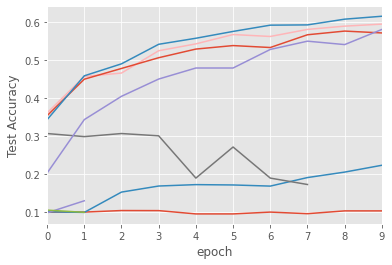

In [66]:
dfs = result.fetch_trial_dataframes()
[d.accuracy.plot() for d in dfs.values()]
plt.xlabel("epoch"); plt.ylabel("Test Accuracy"); 